In [1]:
!pip install --upgrade scikit-learn
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 37.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00


In [65]:
# Import Cells
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy
from openai import OpenAI
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, validation_curve

In [3]:
# Load Data and API Key
data = pd.read_csv('Data.csv')
data_init = pd.read_csv('Data.csv')
with open('API_KEY.txt', "r") as f:
    API_KEY = f.read().strip('\n')
    # print(API_KEY)

# OpenAI ChatGPT Configuration

In [4]:
# OpenAI Model

client = OpenAI(
    api_key=API_KEY
)

OpenAI_Model = 'gpt-3.5-turbo'
Temperature_Model = 0.3
Max_Tokens = 500

# OpenAI Functions

In [5]:
system_message1 = """
You are an avid YouTube watcher.
You have watched many videos, and know which videos are clickbait and which are not.
Your role today is to tell me information that a frequent YouTube watcher would know.
"""

system_message2 = """
You are a literature expert.
You have read many books, read many sentences, and know a lot about sentence structure and similarities.
Your role today is to give me a score of how similar two sentences are..
"""

def generatePrompt1(title, summary):
  prompt1 = f"""
  You watch many Youtube Videos. I will give you the title and the summarized transcript of a YouTube video.
  I want you to judge whether the video is clickbait or not based on the title and the summarized transcript.
  Your response should only be "Yes" or "No".
  Incorrect Response: I think the video is a clickbait
  Correct Response: Yes

  The Title: {title}
  The Transcript: {summary}
  """
  return prompt1

def generatePrompt2(summary):
  prompt2 = f"""
  I will give you the summarized transcript of a YouTube video.
  I want you to try and guess what the title of the video is.
  Your response should only be the title itself, and nothing else.
  Incorrect Response: I think the video title is [Video title]
  Correct Response: [Video title]

  The transcript: {summary}
  """
  return prompt2

def generatePrompt3(sentence1, sentence2):
  prompt3 = f"""
  I'm going to give you two sentences.
  You are to judge how similar these two sentences are with each other and rate them in percentage.
  Your output should only be the percentage itself, and nothing else.
  Incorrect output : I think the sentences are similar, and would rate them at around 80%
  Correct output : 85%

  Sentence 1: {sentence1}
  Sentence 2: {sentence2}
  """
  return prompt3

print(generatePrompt3('Title1', 'Title2'))


  I'm going to give you two sentences.
  You are to judge how similar these two sentences are with each other and rate them in percentage.
  Your output should only be the percentage itself, and nothing else.
  Incorrect output : I think the sentences are similar, and would rate them at around 80%
  Correct output : 85%

  Sentence 1: Title1
  Sentence 2: Title2
  


In [6]:
def Direct_Clickbait_Detection(title, summary):
      completion = client.chat.completions.create(
      model = OpenAI_Model,
      temperature=Temperature_Model,
      max_tokens=Max_Tokens,
      messages=[
          {'role' : 'system', 'content' : system_message1},
          {'role' : 'user', 'content' : generatePrompt1(title, summary)}
        ]
      )
      return completion.choices[0].message.content

def Title_Predictor(summary):
      completion = client.chat.completions.create(
      model = OpenAI_Model,
      temperature=Temperature_Model,
      max_tokens=Max_Tokens,
      messages=[
          {'role' : 'system', 'content' : system_message1},
          {'role' : 'user', 'content' : generatePrompt2(summary)}
        ]
      )
      return completion.choices[0].message.content

def Sentence_Similarity(title1, title2):
      completion = client.chat.completions.create(
      model = OpenAI_Model,
      temperature=Temperature_Model,
      max_tokens=Max_Tokens,
      messages=[
          {'role' : 'system', 'content' : system_message2},
          {'role' : 'user', 'content' : generatePrompt3(title1, title2)}
        ]
      )
      return completion.choices[0].message.content

# print(Direct_Clickbait_Detection('GIRLFRIEND Controls My Life For 24 HOURS! - Challenge', 'Morgan reluctantly allows his girlfriend to control his day for 24 hours, enduring tasks like an ice bath, wearing a chicken costume, embarrassing himself during a KFC delivery, and even cutting his hair poorly. The day culminates with building a tent to sleep outside and ends with an awkward call to his ex, all for the sake of a YouTube video.'))
# print(Sentence_Similarity('Among Us In Real Life, With ACTUAL Detectives... (Impostor IQ 999)', 'Real Life Among Us: YouTubers vs. Detectives in Space Arena'))

# Exploratory Data Analysis

In [63]:
data
# len(data)

,Unnamed: 0,ID,Video Title,Views,Likes,Dislikes,Clickbait,Transcript,Predicted_Title,Direct_Prediction,Similarity_Score
0,0,ZZtYAOpHVYk,10 Real Life GIANTS,9244943,64025,6508,1,"10 real-life giants, including individuals lik...","""10 REAL-LIFE GIANTS YOU WON'T BELIEVE EXIST""",1,0.80
1,1,8Iuvf4_NMF4,15 Biggest Animals You Won't Believe Actually ...,8380807,48083,5299,1,"15 of the biggest animals, including the giant...",15 Biggest Animals in the World,1,0.70
2,2,4TiITQDPClI,THESE GLASSES CURED MY COLORBLINDNESS!,29804390,2323366,280267,1,A colorblind YouTuber receives glasses that cu...,"""COLORBLIND YouTuber SEES COLORS for the FIRST...",1,0.70
3,3,k1TkanTFMYc,CRAZY Roller Coasters YOU WONT BELIEVE EXIST !,14056313,100767,4691,1,A commentary on various terrifying amusement p...,"""The Most Terrifying Amusement Park Rides You ...",1,0.70
4,4,jPiPvAafhPU,LUCKY PEOPLE Who Avoided VERY CLOSE CALLS,13431007,136547,6835,1,A compilation of instances where people narrow...,"""Lucky People Escaping Disasters Compilation w...",1,0.40
...,...,...,...,...,...,...,...,...,...,...,...
124,188,8xaMdOIsGLE,You won't believe these CRAZY SIGHTINGS! (Can'...,16269467,380222,9096,1,various photos with hidden creepy or paranorma...,"""Reacting to Creepy Photos with Hidden Secrets""",1,0.40
125,189,BAp1m2Iw-FI,Only KIDS Can Hear This Sound..,37139,2053,77,1,Various unique abilities that many kids have b...,"""10 Unique Abilities Kids Have That Adults Don...",1,0.55
126,190,ld0xulQ8NU8,Unboxing Samsung's Mind Bending New Display...,1002665,40521,1709,0,Will introduces Lew to high-end gaming setups ...,"""Upgrading My Gaming Setup with Lew from Unbox...",1,0.40
127,191,K5Qq2cKgd-A,5 SCARIEST THINGS YouTubers Caught On Camera! ...,69836,5045,367,1,YouTuber Adventure showcases five of the scari...,Top 5 Scariest YouTube Moments Captured on Camera,1,0.70


In [ ]:
data.count()

ID             193
Video Title    193
Views          193
Likes          193
Dislikes       193
Clickbait      193
Transcript     193
dtype: int64

In [ ]:
# data['Transcript'].unique()

In [ ]:
# data[data.Transcript == 'Unavailable'].count()
# data[data.Transcript == 'Official Video'].count()
data[data.Transcript == 'Music Video'].count()

ID             15
Video Title    15
Views          15
Likes          15
Dislikes       15
Clickbait      15
Transcript     15
dtype: int64

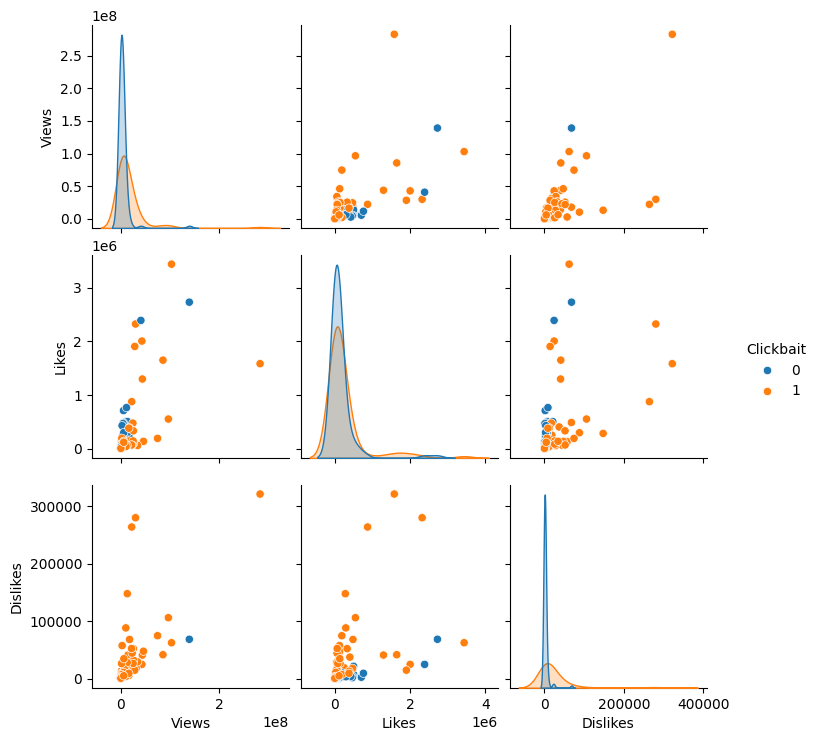

In [ ]:
sb.pairplot(data, hue='Clickbait')

<Axes: >

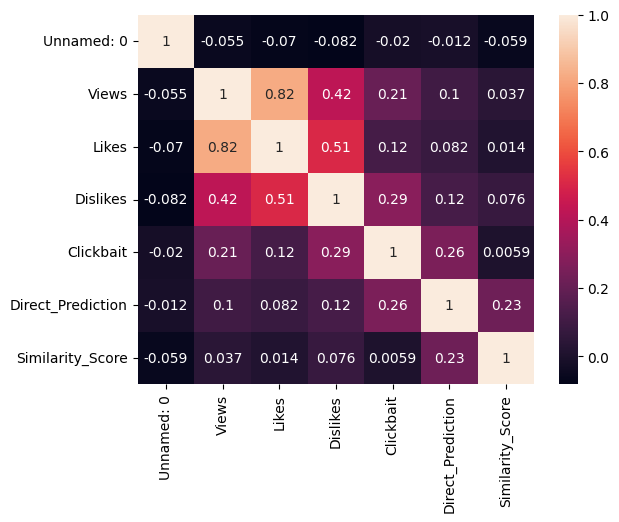

In [62]:
sb.heatmap(data.corr(numeric_only=True), annot=True)

In [ ]:
data['Clickbait'].value_counts()

Clickbait
1    97
0    96
Name: count, dtype: int64

# Preprocessing

In [7]:
data_init = data.copy()

In [8]:
data.drop(data[data.Transcript == 'Unavailable'].index, inplace=True)
data.drop(data[data.Transcript == 'Official Video'].index, inplace=True)
data.drop(data[data.Transcript == 'Music Video'].index, inplace=True)

In [68]:
# data.shape
data_init

,ID,Video Title,Views,Likes,Dislikes,Clickbait,Transcript
0,ZZtYAOpHVYk,10 Real Life GIANTS,9244943,64025,6508,1,"10 real-life giants, including individuals lik..."
1,8Iuvf4_NMF4,15 Biggest Animals You Won't Believe Actually ...,8380807,48083,5299,1,"15 of the biggest animals, including the giant..."
2,4TiITQDPClI,THESE GLASSES CURED MY COLORBLINDNESS!,29804390,2323366,280267,1,A colorblind YouTuber receives glasses that cu...
3,k1TkanTFMYc,CRAZY Roller Coasters YOU WONT BELIEVE EXIST !,14056313,100767,4691,1,A commentary on various terrifying amusement p...
4,jPiPvAafhPU,LUCKY PEOPLE Who Avoided VERY CLOSE CALLS,13431007,136547,6835,1,A compilation of instances where people narrow...
...,...,...,...,...,...,...,...
188,8xaMdOIsGLE,You won't believe these CRAZY SIGHTINGS! (Can'...,16269467,380222,9096,1,various photos with hidden creepy or paranorma...
189,BAp1m2Iw-FI,Only KIDS Can Hear This Sound..,37139,2053,77,1,Various unique abilities that many kids have b...
190,ld0xulQ8NU8,Unboxing Samsung's Mind Bending New Display...,1002665,40521,1709,0,Will introduces Lew to high-end gaming setups ...
191,K5Qq2cKgd-A,5 SCARIEST THINGS YouTubers Caught On Camera! ...,69836,5045,367,1,YouTuber Adventure showcases five of the scari...


In [ ]:
data.insert(7, 'Predicted_Title', np.NaN, allow_duplicates=True)
data.insert(8, 'Direct_Prediction', np.NaN, allow_duplicates=True)
data.insert(9, 'Similarity_Score', np.NaN, allow_duplicates=True)

In [ ]:
# BE VERY CAREFUL WHEN RUNNING THIS. WILL COST YOU API USAGE.

for i in range(len(data)):
  # data['Direct_Prediction'].iloc[i] = Direct_Clickbait_Detection(data['Video Title'].iloc[i], data['Transcript'].iloc[i])
  # data['Predicted_Title'].iloc[i] = Title_Predictor(data['Transcript'].iloc[i])
  # data['Similarity_Score'].iloc[i] = Sentence_Similarity(data['Video Title'].iloc[i], data['Predicted_Title'].iloc[i])

<ipython-input-99-dba74574a832>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Similarity_Score'].iloc[i] = Sentence_Similarity(data['Video Title'].iloc[i], data['Predicted_Title'].iloc[i])


In [ ]:
# Save dataset to prevent reusing OpenAI API

# data.to_csv('Sample.csv')

In [9]:
# Use prepared data

data = pd.read_csv('Sample.csv')

In [10]:
encoder = preprocessing.LabelEncoder()
data['Direct_Prediction'] = encoder.fit_transform(data['Direct_Prediction'])

data['Similarity_Score'] = data['Similarity_Score'].apply(lambda x: int(x.replace('%',''))/100)

In [11]:
X1 = data[["Views", "Likes", "Dislikes"]]
Y = data["Clickbait"]

X2 = data[["Views", "Likes", "Dislikes", "Direct_Prediction"]]
X3 = data[["Views", "Likes", "Dislikes", "Similarity_Score"]]
X4 = data[["Views", "Likes", "Dislikes", "Direct_Prediction", "Similarity_Score"]]

X1Train, X1Test, Y1Train, Y1Test = train_test_split(X1, Y, test_size=0.3, random_state=4)
X2Train, X2Test, Y2Train, Y2Test = train_test_split(X2, Y, test_size=0.3, random_state=4)
X3Train, X3Test, Y3Train, Y3Test = train_test_split(X3, Y, test_size=0.3, random_state=4)
X4Train, X4Test, Y4Train, Y4Test = train_test_split(X4, Y, test_size=0.3, random_state=4)

# Random Forest


In [ ]:
# Save and Load Model
# Save
# with open('model.pkl','wb') as f:
#     pickle.dump(Model,f)

# Load
# with open('model.pkl', 'rb') as f:
#     Model = pickle.load(f)

In [ ]:
# Random Forest is just strictly better. Ignore LGR and GNB.
# Very prone to overfitting

parameters = {
    # 'n_estimators' : (60, 70, 80, 90, 100),
    # 'criterion' : ('gini', 'entropy', 'log_loss'),
    # 'max_depth' : (10, 20, 30, 40, 50, 60, 70, 80, 90, 100),
    # 'max_features' : ('auto', 'sqrt', 'log2', None),
    # 'max_leaf_nodes' : (10, 20, 30, 40, 50)
    }


RF1 = RandomForestClassifier()
RF2 = RandomForestClassifier()
RF3 = RandomForestClassifier()
RF4 = RandomForestClassifier()

Model1 = RF1.fit(X1Train, Y1Train)
Model2 = RF2.fit(X2Train, Y2Train)
Model3 = RF3.fit(X3Train, Y3Train)
Model4 = RF4.fit(X4Train, Y4Train)

Model1 Train Accuracy :  1.0
Model1 Test Accuracy : 
               precision    recall  f1-score   support

           0       0.88      0.81      0.84        26
           1       0.67      0.77      0.71        13

    accuracy                           0.79        39
   macro avg       0.77      0.79      0.78        39
weighted avg       0.81      0.79      0.80        39



<Axes: >

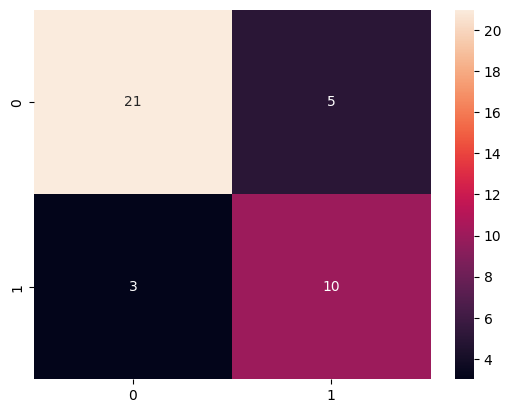

In [ ]:
# Model1 = RF.fit(X1Train, Y1Train)
print("Model1 Train Accuracy : ", accuracy_score(Y1Train, Model1.predict(X1Train)))
print("Model1 Test Accuracy : \n", classification_report(Y1Test, Model1.predict(X1Test)))
sb.heatmap(confusion_matrix(Y1Test, Model1.predict(X1Test)), annot=True)

Model2 Train Accuracy :  1.0
Model2 Test Accuracy : 
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        26
           1       0.77      0.77      0.77        13

    accuracy                           0.85        39
   macro avg       0.83      0.83      0.83        39
weighted avg       0.85      0.85      0.85        39



<Axes: >

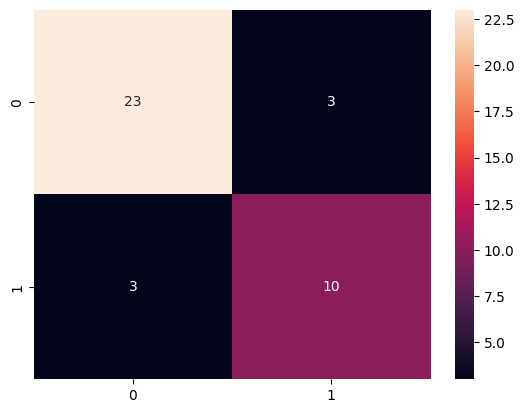

In [ ]:
# Model2 = RF.fit(X2Train, Y2Train)
print("Model2 Train Accuracy : ", accuracy_score(Y2Train, Model2.predict(X2Train)))
print("Model2 Test Accuracy : \n", classification_report(Y2Test, Model2.predict(X2Test)))
sb.heatmap(confusion_matrix(Y2Test, Model2.predict(X2Test)), annot=True)

Model3 Train Accuracy :  1.0
Model3 Test Accuracy : 
               precision    recall  f1-score   support

           0       0.91      0.81      0.86        26
           1       0.69      0.85      0.76        13

    accuracy                           0.82        39
   macro avg       0.80      0.83      0.81        39
weighted avg       0.84      0.82      0.82        39



<Axes: >

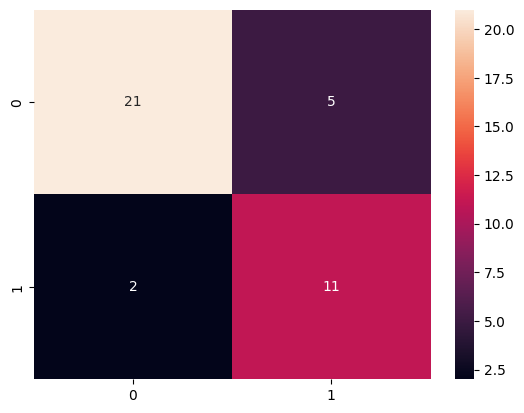

In [ ]:
# Model3 = RF.fit(X3Train, Y3Train)
print("Model3 Train Accuracy : ", accuracy_score(Y3Train, Model3.predict(X3Train)))
print("Model3 Test Accuracy : \n", classification_report(Y3Test, Model3.predict(X3Test)))
sb.heatmap(confusion_matrix(Y3Test, Model3.predict(X3Test)), annot=True)

Model4 Train Accuracy :  1.0
Model4 Test Accuracy : 
               precision    recall  f1-score   support

           0       0.92      0.88      0.90        26
           1       0.79      0.85      0.81        13

    accuracy                           0.87        39
   macro avg       0.85      0.87      0.86        39
weighted avg       0.88      0.87      0.87        39



<Axes: >

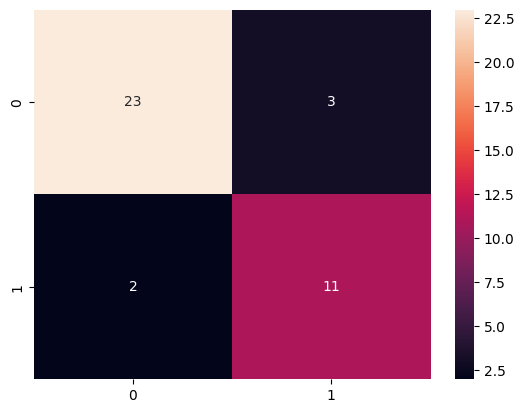

In [ ]:
# Model4 = RF.fit(X4Train, Y4Train)
print("Model4 Train Accuracy : ", accuracy_score(Y4Train, Model4.predict(X4Train)))
print("Model4 Test Accuracy : \n", classification_report(Y4Test, Model4.predict(X4Test)))
sb.heatmap(confusion_matrix(Y4Test, Model4.predict(X4Test)), annot=True)

Model5 Accuracy :
               precision    recall  f1-score   support

           0       0.83      0.23      0.36        66
           1       0.54      0.95      0.69        63

    accuracy                           0.58       129
   macro avg       0.69      0.59      0.52       129
weighted avg       0.69      0.58      0.52       129



<Axes: >

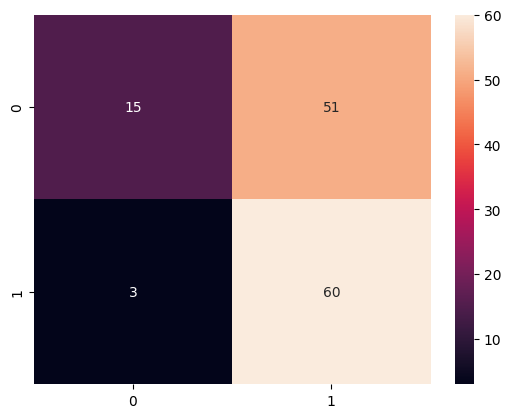

In [ ]:
# Model 5
print("Model5 Accuracy :\n", classification_report(data['Clickbait'], data['Direct_Prediction']))
sb.heatmap(confusion_matrix(data['Clickbait'], data['Direct_Prediction']), annot=True)

In [ ]:
# RFTest = Model.predict(XTest)
# RFTrain = Model.predict(XTrain)


# print("Test Accuracy : ", accuracy_score(YTest, RFTest))
print("Train Accuracy : ", accuracy_score(data['Clickbait'], data['Direct_Prediction']))
# print(Model.best_params_)
# print(Model.best_estimator_)

Train Accuracy :  0.5813953488372093


# Logistic Regression


In [ ]:
LGR = LogisticRegression().fit(X4Train, Y4Train)
LGRTest = LGR.predict(X4Test)
LGRTrain = LGR.predict(X4Train)

Train Accuracy :  0.6666666666666666
Test Accuracy :
               precision    recall  f1-score   support

           0       0.94      0.62      0.74        26
           1       0.55      0.92      0.69        13

    accuracy                           0.72        39
   macro avg       0.74      0.77      0.71        39
weighted avg       0.81      0.72      0.72        39



<Axes: >

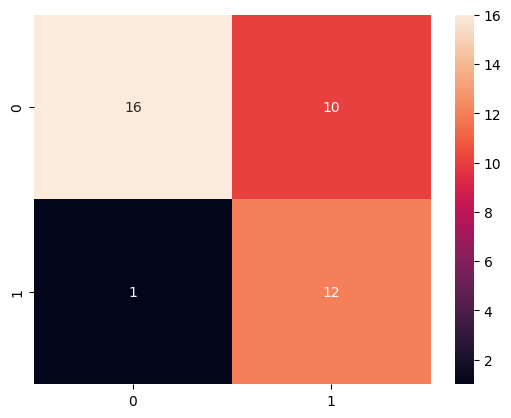

In [59]:
print("Train Accuracy : ", accuracy_score(Y4Train, LGRTrain))
print("Test Accuracy :\n", classification_report(Y4Test, LGRTest))
sb.heatmap(confusion_matrix(Y4Test, LGRTest), annot=True)

# Gaussian Naive Bayes

In [58]:
GNB = GaussianNB().fit(X4Train, Y4Train)
GNBTest = GNB.predict(X4Test)
GNBTrain = GNB.predict(X4Train)


Test Accuracy :  0.717948717948718
Test Accuracy :
               precision    recall  f1-score   support

           0       0.71      0.96      0.82        26
           1       0.75      0.23      0.35        13

    accuracy                           0.72        39
   macro avg       0.73      0.60      0.59        39
weighted avg       0.73      0.72      0.66        39



<Axes: >

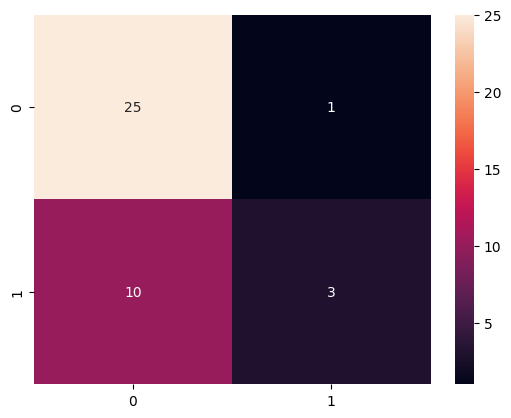

In [60]:
print("Test Accuracy : ", accuracy_score(Y4Test, GNBTest))
print("Test Accuracy :\n", classification_report(Y4Test, GNBTest))
sb.heatmap(confusion_matrix(Y4Test, GNBTest), annot=True)

# Neural Network

In [48]:
base_model = Sequential(
    [
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

optim = Adam(learning_rate=0.01)
base_model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
base_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               1536      
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 2)                 130       
                                                                 
Total params: 42818 (167.26 KB)
Trainable params: 42818 (167.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
Y4Test.shape

(39,)

In [49]:
mlphist = base_model.fit(X4Train, Y4Train, epochs = 100, verbose=1)

Epoch 1/100
3/3 [==============================] - 1s 6ms/step - loss: 770935.3125 - accuracy: 0.4889
Epoch 2/100
3/3 [==============================] - 0s 6ms/step - loss: 896785.1250 - accuracy: 0.5556
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 721961.4375 - accuracy: 0.5556
Epoch 4/100
3/3 [==============================] - 0s 8ms/step - loss: 64506.1211 - accuracy: 0.4889
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 164051.9531 - accuracy: 0.5556
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 188804.1562 - accuracy: 0.5556
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 45508.4062 - accuracy: 0.4889
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 219230.5312 - accuracy: 0.5556
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 213368.4375 - accuracy: 0.5556
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 86568.6875 -

In [52]:
base_mlp = base_model.predict(X4Test)


for i in range(len(base_mlp)):
  if base_mlp[i] >= 0.8:
    base_mlp[i] = 1
  else:
    base_mlp[i] = 0

2/2 [==============================] - 0s 10ms/step


array([[0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

MLP Test Accuracy : 
               precision    recall  f1-score   support

           0       0.77      0.65      0.71        26
           1       0.47      0.62      0.53        13

    accuracy                           0.64        39
   macro avg       0.62      0.63      0.62        39
weighted avg       0.67      0.64      0.65        39



<Axes: >

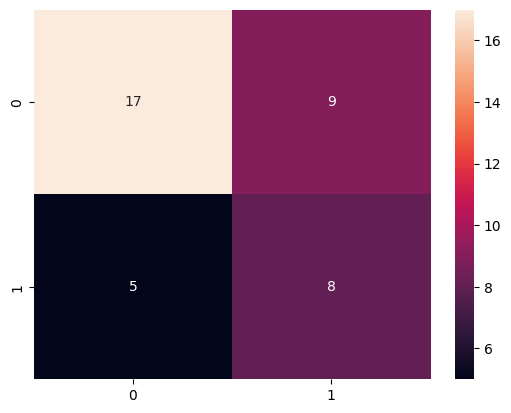

In [61]:
print("MLP Test Accuracy : \n", classification_report(Y1Test, base_mlp))
sb.heatmap(confusion_matrix(Y4Test, base_mlp), annot=True)

# Support Vector Machine

In [66]:
SVM = SVC().fit(X4Train, Y4Train)
SVMTest = SVM.predict(X4Test)
SVMTrain = SVM.predict(X4Train)

Train Accuracy :  0.7444444444444445
Test Accuracy :
               precision    recall  f1-score   support

           0       0.76      0.85      0.80        26
           1       0.60      0.46      0.52        13

    accuracy                           0.72        39
   macro avg       0.68      0.65      0.66        39
weighted avg       0.71      0.72      0.71        39



<Axes: >

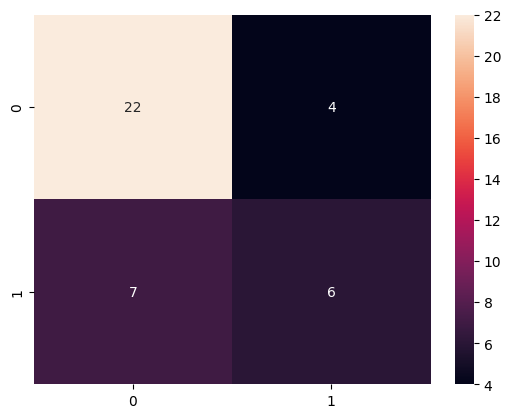

In [67]:
print("Train Accuracy : ", accuracy_score(Y4Train, SVMTrain))
print("Test Accuracy :\n", classification_report(Y4Test, SVMTest))
sb.heatmap(confusion_matrix(Y4Test, SVMTest), annot=True)